In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

path_to_fDepth     = '/home/gterren/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data       = '/home/gterren/dynamic_update/data'
path_to_validation = '/home/gterren/dynamic_update/validation'

(87600, 4)
    forget_rate_f     WIS_f
0           0.125  0.056774
1           0.250  0.060574
2           0.500  0.064680
3           1.000  0.067908
4           2.000  0.070652
5           3.000  0.071748
6           4.000  0.072056
7           5.000  0.072401
8           6.000  0.072796
9           7.000  0.073092
10          8.000  0.073354
11          9.000  0.073438


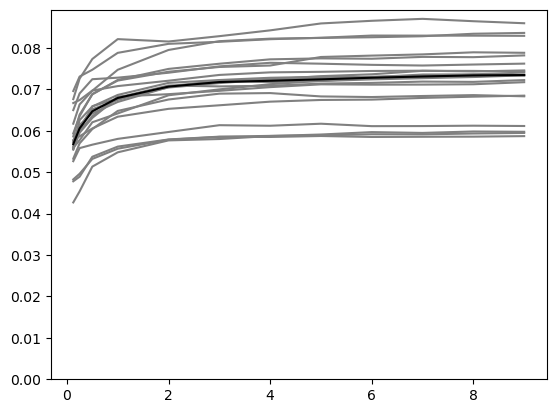

In [4]:
param_name = 'forget_rate_f'

df_ = pd.read_csv(path_to_validation + f'/validation_ffc-WIS-{param_name}-144.csv')
df_ = df_[['asset', 'day', param_name, 'WIS_f']]
print(df_.shape)

df_ = df_.groupby(['asset', param_name]).agg({'WIS_f': 'median'}).reset_index(drop = False)
#print(df_)

df_p_ = df_.groupby([param_name]).agg({'WIS_f': 'median'}).reset_index(drop = False)
print(df_p_)

plt.figure()
for asset in df_['asset'].unique():
    plt.plot(df_.loc[df_['asset'] == asset, param_name], df_.loc[df_['asset'] == asset, 'WIS_f'], 'gray')
plt.plot(df_p_[param_name], df_p_['WIS_f'], 'k')
plt.ylim(0,)
plt.show()

In [132]:
param_name = 'trust_rate'
param = 6

df_ = pd.read_csv(path_to_validation + f'/validation_ffc-WIS-{param_name}-144.csv')
print(df_.columns)

df_ = df_[[param_name, 'asset', 'lat', 'lot', 'day', 'WIS_e', 'WIS_f', 'RMSE_s', 'RMSE_tau']]

df_ = df_.rename(columns = {'lat': 'day', 'lot': 'lon', 'day': 'lat'})

df_['x'] = np.cos(np.radians(df_['lat']))*np.cos(np.radians(df_['lon']))
df_['y'] = np.cos(np.radians(df_['lat']))*np.sin(np.radians(df_['lon']))
df_['z'] = np.sin(np.radians(df_['lat']))

X_ = df_.loc[df_[param_name] == param].reset_index(drop=True).sort_values(by=['asset', 'day'])
#X_ = X_[['lon', 'lat', 'WIS_e', 'WIS_f', 'RMSE_s', 'RMSE_tau']]
X_ = X_[['x', 'y', 'z', 'WIS_e', 'RMSE_s', 'RMSE_tau']]
print(X_)

idx_ = df_.groupby(['asset', 'day'])['WIS_f'].idxmin()

y_ = df_.loc[idx_, ['asset', 'day', param_name]].reset_index(drop=True).sort_values(by=['asset', 'day'])
y_ = y_[[param_name]]
print(y_)

Index(['forget_rate_f', 'forget_rate_e', 'length_scale_f', 'length_scale_e',
       'lookup_rate', 'trust_rate', 'nu', 'gamma', 'xi', 'kappa_min',
       'kappa_max', 'time', 'asset', 'lat', 'lot', 'day', 'n_scenarios',
       'WIS_e', 'WIS_f', 'RMSE_tau', 'RMSE_s'],
      dtype='object')
             x         y         z     WIS_e    RMSE_s  RMSE_tau
0    -0.127440 -0.843107  0.522427  0.060618  0.136087  0.163793
1    -0.127440 -0.843107  0.522427  0.033033  0.084439  0.048790
2    -0.127440 -0.843107  0.522427  0.054380  0.110096  0.135747
3    -0.127440 -0.843107  0.522427  0.026322  0.074688  0.056986
4    -0.127440 -0.843107  0.522427  0.053096  0.099781  0.291639
...        ...       ...       ...       ...       ...       ...
7295 -0.134587 -0.815014  0.563594  0.066805  0.132698  0.300349
7296 -0.134587 -0.815014  0.563594  0.067276  0.165981  0.176693
7297 -0.134587 -0.815014  0.563594  0.056375  0.120401  0.124998
7298 -0.134587 -0.815014  0.563594  0.036923  0.078026  0.03

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_, y_, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Standardize features (important for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit LassoCV model
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 100),
                   cv=10, 
                   max_iter=10000,
                   fit_intercept=True, 
                   random_state=42).fit(X_train_scaled, y_train.to_numpy().ravel())

# lasso_cv = RidgeCV(alphas=np.logspace(-6, 6, 100),
#                    cv=10, 
#                    fit_intercept=True).fit(X_train_scaled, y_train.to_numpy().ravel())

# Best alpha found
print("Best alpha:", lasso_cv.alpha_)

# Coefficients
print("Lasso coefficients:", lasso_cv.coef_)

# Score on test data
print("R^2 score on test set:", lasso_cv.score(X_test_scaled, y_test.to_numpy().ravel()))

print("RMSE:", np.sqrt(mean_squared_error(lasso_cv.predict(X_test_scaled), y_test)))
print("MAPE:", mean_absolute_percentage_error(lasso_cv.predict(X_test_scaled), y_test))
print(lasso_cv.alpha_)
# plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), marker='o')
# plt.axvline(lasso_cv.alpha_, linestyle='--', color='r', label='Best alpha')
# plt.xlabel("Alpha")
# plt.ylabel("Mean Squared Error")
# plt.title("LassoCV - MSE vs Alpha")
# plt.legend()
# plt.show()

(5840, 6) (1460, 6) (5840, 1) (1460, 1)
Best alpha: 1.1497569953977356
Lasso coefficients: [-1.42873549 -6.75641334  6.6391658   0.99032949 -3.59686312 -1.00524249]
R^2 score on test set: 0.12610140214122778
RMSE: 8.843617876973013
MAPE: 0.5074590711781373
1.1497569953977356
